Loading and preprocessing data...


<ipython-input-3-05d2ac5a084d>:43: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[timestamp_col] = pd.to_datetime(df[timestamp_col])


Data loaded. Sample data:
                             open    high     low   close    volume
date                                                               
2023-11-01 09:30:00-04:00  171.05  171.34  170.89  171.10  557409.0
2023-11-01 09:31:00-04:00  171.10  171.12  170.55  170.59  137110.0
2023-11-01 09:32:00-04:00  170.58  170.65  170.45  170.53  153009.0
2023-11-01 09:33:00-04:00  170.53  170.63  170.22  170.27  111824.0
2023-11-01 09:34:00-04:00  170.27  170.47  170.12  170.41  186190.0
Index type: <class 'pandas.core.indexes.base.Index'>
Calculating half-hour returns...
Using 'open' for 'Open'
Using 'high' for 'High'
Using 'low' for 'Low'
Using 'close' for 'Close'
Returns calculated. Sample data:
                       Open    High     Low   Close    return  next_return  \
timestamp                                                                    
2023-01-01 00:30:00  171.11  171.97  170.78  171.83  0.004384    -0.002153   
2023-01-01 01:00:00  171.83  172.08  171.38  171.

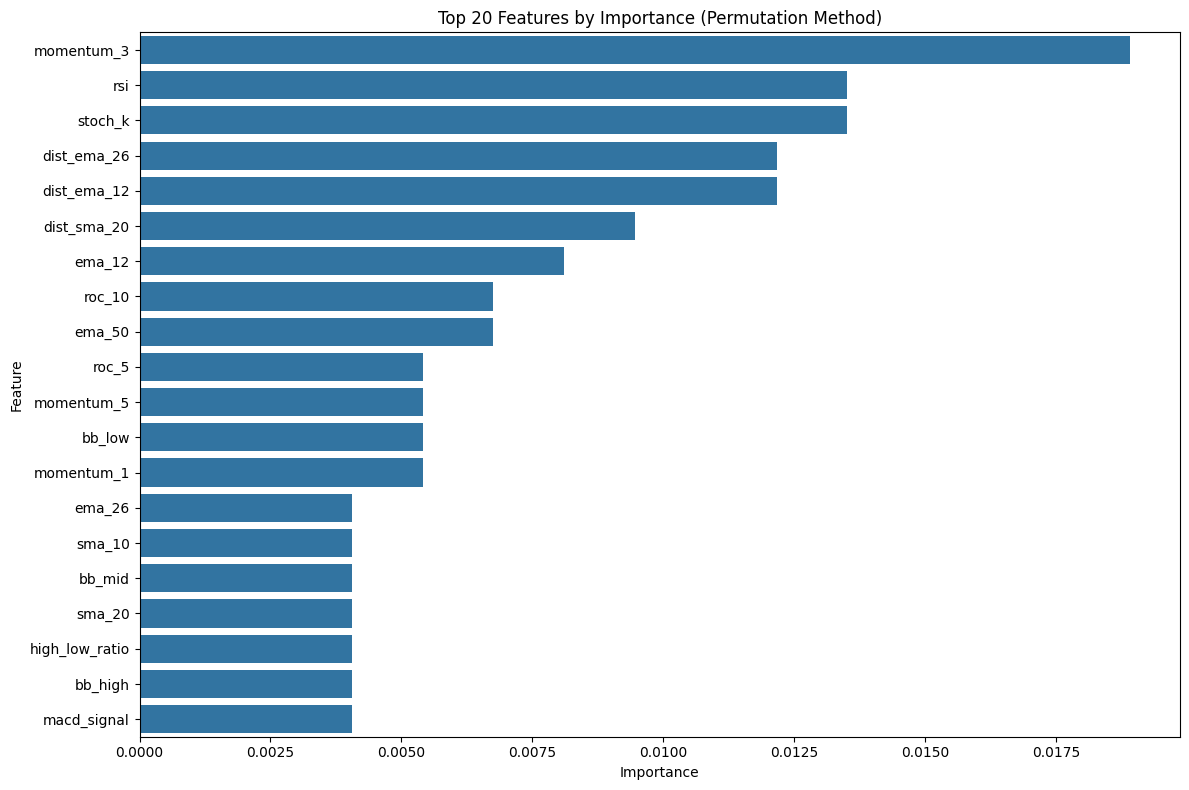

Analysis complete! Results saved to feature_importance.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def loadData(path):
    # Load data
    df = pd.read_csv(path)

    # timestamp column
    timeColNames = ['timestamp', 'date', 'time', 'datetime', 'Date', 'Time', 'DateTime']
    timeCol = None

    for col in timeColNames:
        if col in df.columns:
            timeCol = col
            break

    if timeCol is None:
        print("No standard timestamp column found. Here are the first few rows and columns:")
        print(df.head())
        print("\nColumn names:", df.columns.tolist())

        timeCol = input("Please enter the name of the timestamp column (or press Enter to skip): ")

        if not timeCol or timeCol not in df.columns:
            print("No valid timestamp column provided. Will create a timestamp from index.")
            df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='1min')
            timeCol = 'timestamp'

    # Convert to datetim
    try:
        df[timeCol] = pd.to_datetime(df[timeCol])
        df.set_index(timeCol, inplace=True)
    except Exception as e:
        print(f"Error converting timestamp column: {e}")
        print("Creating artificial timestamp index...")
        df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='1min')
        df.set_index('timestamp', inplace=True)

    df.dropna(inplace=True)
    return df

def calcReturns(df, mins=30):
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Warning: Index is not a DatetimeIndex. Creating a datetime index...")
        df.reset_index(inplace=True)
        df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='1min')
        df.set_index('timestamp', inplace=True)

    agg = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}

    if 'Volume' in df.columns:
        agg['Volume'] = 'sum'

    reqCols = ['Open', 'High', 'Low', 'Close']
    missCols = [col for col in reqCols if col not in df.columns]

    if missCols:
        print(f"Warning: Missing required columns: {missCols}")
        altCols = {
            'Open': ['open', 'OPEN', 'Open Price', 'OpenPrice'],
            'High': ['high', 'HIGH', 'High Price', 'HighPrice'],
            'Low': ['low', 'LOW', 'Low Price', 'LowPrice'],
            'Close': ['close', 'CLOSE', 'Close Price', 'ClosePrice', 'Adj Close', 'AdjClose']
        }

        for req in missCols:
            for alt in altCols[req]:
                if alt in df.columns:
                    print(f"Using '{alt}' for '{req}'")
                    df[req] = df[alt]
                    break

        missCols = [col for col in reqCols if col not in df.columns]
        if missCols:
            raise ValueError(f"Still missing required columns after attempted mapping: {missCols}")

    resampled = df.resample(f'{mins}min').agg(agg).dropna()
    resampled['return'] = resampled['Close'].pct_change()
    resampled['nextRet'] = resampled['return'].shift(-1)
    resampled['target'] = (resampled['nextRet'] > 0).astype(int)

    return resampled.dropna()

def calcSMA(series, window):
    return series.rolling(window=window).mean()

def calcEMA(series, window):
    return series.ewm(span=window, adjust=False).mean()

def calcBB(series, window=20, numStd=2):
    sma = calcSMA(series, window)
    std = series.rolling(window=window).std()
    upper = sma + (std * numStd)
    lower = sma - (std * numStd)
    return upper, sma, lower

def calcRSI(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avgGain = gain.rolling(window=window).mean()
    avgLoss = loss.rolling(window=window).mean()

    avgLoss = avgLoss.replace(0, 0.00001)

    rs = avgGain / avgLoss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calcMACD(series, fast=12, slow=26, signal=9):
    emaFast = calcEMA(series, fast)
    emaSlow = calcEMA(series, slow)
    macd = emaFast - emaSlow
    sigLine = calcEMA(macd, signal)
    hist = macd - sigLine
    return macd, sigLine, hist

def calcStoch(high, low, close, kWin=14, dWin=3):
    lowest = low.rolling(window=kWin).min()
    highest = high.rolling(window=kWin).max()

    denom = highest - lowest
    denom = denom.replace(0, 0.00001)

    k = 100 * ((close - lowest) / denom)
    d = k.rolling(window=dWin).mean()
    return k, d

def addIndicators(df):
    df = df.copy()

    df['bbHigh'], df['bbMid'], df['bbLow'] = calcBB(df['Close'])
    df['bbMid'] = df['bbMid'].replace(0, 0.00001)
    df['bbWidth'] = (df['bbHigh'] - df['bbLow']) / df['bbMid']

    df['bbRange'] = df['bbHigh'] - df['bbLow']
    df['bbRange'] = df['bbRange'].replace(0, 0.00001)
    df['bbPct'] = (df['Close'] - df['bbLow']) / df['bbRange']

    df['rsi'] = calcRSI(df['Close'])

    df['stochK'], df['stochD'] = calcStoch(df['High'], df['Low'], df['Close'])

    df['macd'], df['signal'], df['hist'] = calcMACD(df['Close'])

    df['ema12'] = calcEMA(df['Close'], 12)
    df['ema26'] = calcEMA(df['Close'], 26)
    df['ema50'] = calcEMA(df['Close'], 50)

    df['sma10'] = calcSMA(df['Close'], 10)
    df['sma20'] = calcSMA(df['Close'], 20)
    df['sma50'] = calcSMA(df['Close'], 50)

    df['closeNZ'] = df['Close'].replace(0, 0.00001)
    df['distEma12'] = (df['Close'] - df['ema12']) / df['closeNZ'] * 100
    df['distEma26'] = (df['Close'] - df['ema26']) / df['closeNZ'] * 100
    df['distSma20'] = (df['Close'] - df['sma20']) / df['closeNZ'] * 100

    df['mom1'] = df['Close'].pct_change(1)
    df['mom3'] = df['Close'].pct_change(3)
    df['mom5'] = df['Close'].pct_change(5)

    df['tr'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift()),
            abs(df['Low'] - df['Close'].shift())
        )
    )
    df['atr'] = df['tr'].rolling(14).mean()

    df['close5'] = df['Close'].shift(5).replace(0, 0.00001)
    df['close10'] = df['Close'].shift(10).replace(0, 0.00001)
    df['roc5'] = (df['Close'] / df['close5'] - 1) * 100
    df['roc10'] = (df['Close'] / df['close10'] - 1) * 100

    df['lowNZ'] = df['Low'].replace(0, 0.00001)
    df['hlRatio'] = df['High'] / df['lowNZ']

    df['ema12X'] = np.where(
        (df['Close'] > df['ema12']) & (df['Close'].shift() < df['ema12'].shift()), 1,
        np.where((df['Close'] < df['ema12']) & (df['Close'].shift() > df['ema12'].shift()), -1, 0)
    )

    df['sma20X'] = np.where(
        (df['Close'] > df['sma20']) & (df['Close'].shift() < df['sma20'].shift()), 1,
        np.where((df['Close'] < df['sma20']) & (df['Close'].shift() > df['sma20'].shift()), -1, 0)
    )

    df = df.drop(['closeNZ', 'bbRange', 'close5',
                  'close10', 'lowNZ'], axis=1, errors='ignore')

    return df.dropna()

def prepFeatures(df):
    unwanted = ['Open', 'High', 'Low', 'Close', 'return', 'nextRet', 'target']
    if 'Volume' in df.columns:
        unwanted.append('Volume')

    features = [col for col in df.columns if col not in unwanted]

    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])
    y = df['target']

    return X, y, features

def trainSVM(X, y, featNames):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

    params = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
    }

    grid = GridSearchCV(
        estimator=SVC(probability=True),
        param_grid=params,
        cv=3,
        scoring='f1',
        verbose=1
    )

    grid.fit(XTrain, yTrain)
    model = grid.best_estimator_
    yPred = model.predict(XTest)

    print("Best Parameters:", grid.best_params_)
    print("\nClassification Report:")
    print(classification_report(yTest, yPred))
    print("\nConfusion Matrix:")
    conf = confusion_matrix(yTest, yPred)
    print(conf)

    if model.kernel == 'linear':
        imp = np.abs(model.coef_[0])
        featImp = pd.DataFrame(
            {'Feature': featNames, 'Importance': imp}
        ).sort_values('Importance', ascending=False)

        print("\nFeature Importance:")
        print(featImp.head(10))

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=featImp.head(20))
        plt.title('Top 20 Features by Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
    else:
        from sklearn.inspection import permutation_importance

        permImp = permutation_importance(model, XTest, yTest, n_repeats=5)
        featImp = pd.DataFrame(
            {'Feature': featNames, 'Importance': permImp.importances_mean}
        ).sort_values('Importance', ascending=False)

        print("\nFeature Importance (Permutation Method):")
        print(featImp.head(10))

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=featImp.head(20))
        plt.title('Top 20 Features by Importance (Permutation Method)')
        plt.tight_layout()
        plt.savefig('feature_importance_permutation.png')
        plt.show()

    return model, featImp

def main(path):

    df = loadData(path)

    print("Sample data:")
    print(df.head())
    print(f"Index type: {type(df.index)}")

    retDF = calcReturns(df, mins=30)

    print("Returns calculated:")
    print(retDF.head())

    print("Adding technical indicator")
    indDF = addIndicators(retDF)
    print("Technical indicators added)

    nanCnt = indDF.isna().sum().sum()
    if nanCnt > 0:
        print(f"Warning: {nanCnt} NaN values remaining. Dropping rows with NaNs.")
        indDF = indDF.dropna()
        print("Final dataset shape after dropping NaNs:", indDF.shape)

    print("Preparing features")
    X, y, featNames = prepFeatures(indDF)

    print("Training")
    model, featImp = trainSVM(X, y, featNames)

    featImp.to_csv('feature_importance.csv', index=False)

    print("saved to feature_importance.csv")

    return model, indDF, featImp

if __name__ == "__main__":
    path = "/content/AAPL_1min_2months_IB.csv"
    model, df, imp = main(path)